In [1]:
################################################################
#
# Robust Synthetic Control 
#
# Implementation based on: 
# http://www.jmlr.org/papers/volume19/17-777/17-777.pdf
#
################################################################
import numpy as np
import pandas as pd

from tslib.src.models.tsSVDModel import SVDModel
from tslib.src.models.tsALSModel import ALSModel
from tslib.src import tsUtils

class RobustSyntheticControl(object):
    
    # seriesToPredictKey:       (string) the series of interest (key)
    # kSingularValuesToKeep:    (int) the number of singular values to retain
    # M:                        (int) the number of columns for the matrix
    # probObservation:          (float) the independent probability of observation of each entry in the matrix
    # modelType:                (string) SVD or ALS. Default is "SVD"
    # svdMethod:                (string) the SVD method to use (optional)
    # otherSeriesKeysArray:     (array) an array of keys for other series which will be used to predict 

    def __init__(self, seriesToPredictKey, kSingularValuesToKeep, M, probObservation=1.0, modelType='svd', svdMethod='numpy', otherSeriesKeysArray=[]):

        self.seriesToPredictKey = seriesToPredictKey
        self.otherSeriesKeysArray = otherSeriesKeysArray

        self.N = 1 # each series is on its own row
        self.M = M

        self.kSingularValues = kSingularValuesToKeep
        self.svdMethod = svdMethod

        self.p = probObservation

        if (modelType == 'als'):
            self.model = ALSModel(self.seriesToPredictKey, self.kSingularValues, self.N, self.M, probObservation=self.p, otherSeriesKeysArray=self.otherSeriesKeysArray, includePastDataOnly=False)

        elif (modelType == 'svd'):
            self.model = SVDModel(self.seriesToPredictKey, self.kSingularValues, self.N, self.M, probObservation=self.p, svdMethod='numpy', otherSeriesKeysArray=self.otherSeriesKeysArray, includePastDataOnly=False)

        else:
            self.model = SVDModel(self.seriesToPredictKey, self.kSingularValues, self.N, self.M, probObservation=self.p, svdMethod='numpy', otherSeriesKeysArray=self.otherSeriesKeysArray, includePastDataOnly=False)

        self.control = None # these are the synthetic control weights


    # keyToSeriesDictionary: (Pandas dataframe) a key-value Series
    # Note that the keys provided in the constructor MUST all be present
    # The values must be all numpy arrays of floats.
    def fit(self, keyToSeriesDF):
        self.model.fit(keyToSeriesDF)


    # otherKeysToSeriesDFNew:     (Pandas dataframe) needs to contain all keys provided in the model;
    #                               all series/array MUST be of length >= 1, 
    #                               If longer than 1, then the most recent point will be used (for each series)
    def predict(self, otherKeysToSeriesDFNew):
        prediction = np.dot(self.model.weights, otherKeysToSeriesDFNew[self.otherSeriesKeysArray].T)
        return prediction

    # return the synthetic control weights
    def getControl():
        if (self.model.weights is None):
            raise Exception('Before calling getControl() you need to call the fit() method first.')
        else:
            return self.model.weights


In [2]:
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import copy

from tslib.src import tsUtils
# from tslib.src.synthcontrol import RobustSynthaticControl
from tslib.tests import testdata

In [5]:
#Set to local path
df=pd.read_csv('donarPoolData.csv')
df.drop(['Unnamed: 0','Unnamed: 0.1'],axis=1, inplace=True)

In [7]:
LocationDesc=['Brazil', 'Mexico', 'Mauritius', 'Rwanda', 'Indonesia', 'Ghana', 'Turkey', 'Malaysia', 'India']

In [8]:
allColumns = df.columns.values

In [9]:
states = list(np.unique(df['LocationDesc']))
years = np.delete(allColumns, [0])
caStateKey = 'India'
states.remove(caStateKey)
otherStates = states
p = 1.0

In [10]:
trainingYears = ['20200131', '20200214', '20200229', '20200314', '20200331', '20200414']
testYears = ['20200414','20200430', '20200514', '20200530', '20200614', '20200631', '20200718']

trainDataMasterDict = {}
trainDataDict = {}
testDataDict = {}

In [11]:
for key in otherStates:
 series = df.loc[df['LocationDesc'] == key]

 trainDataMasterDict.update({key: series[trainingYears].values[0]})

 # randomly hide training data
 (trainData, pObservation) = tsUtils.randomlyHideValues(copy.deepcopy(trainDataMasterDict[key]), p)
 trainDataDict.update({key: trainData})
 testDataDict.update({key: series[testYears].values[0]})
    
series = df[df['LocationDesc'] == caStateKey]
trainDataMasterDict.update({caStateKey: series[trainingYears].values[0]})
trainDataDict.update({caStateKey: series[trainingYears].values[0]})
testDataDict.update({caStateKey: series[testYears].values[0]})

trainMasterDF = pd.DataFrame(data=trainDataMasterDict)
trainDF = pd.DataFrame(data=trainDataDict)
testDF = pd.DataFrame(data=testDataDict)

In [12]:
trainDF

,Brazil,Ghana,Indonesia,Malaysia,Mauritius,Mexico,Rwanda,Turkey,India
0,0,0,0,8,0,0,0,0,1
1,0,0,0,11,0,0,0,0,2
2,2,0,0,6,0,4,0,0,0
3,149,3,96,213,0,37,1,5,99
4,5566,158,1432,2528,143,1174,74,13526,1295
5,19545,475,3311,2221,181,4184,59,51580,10090


In [13]:
testDF

,Brazil,Ghana,Indonesia,Malaysia,Mauritius,Mexico,Rwanda,Turkey,India
0,19545,475,3311,2221,181,4184,59,51580,10090
1,61925,1438,5279,1015,8,13825,109,55093,23376
2,115978,3456,5888,817,0,23371,44,24545,47134
3,311684,2540,10467,1000,3,48069,83,19193,99830
4,352775,3894,11804,634,2,56173,212,14297,141815
5,534417,5777,18108,186,4,79252,443,21667,253057
6,672819,9319,28497,125,2,112824,514,18811,492300


In [14]:
singvals = 3
rscModel = RobustSyntheticControl(caStateKey, singvals, len(trainDF), probObservation=1.0, modelType='svd', svdMethod='numpy', otherSeriesKeysArray=otherStates)
rscModel.fit(trainDF)
denoisedDF = rscModel.model.denoisedDF()

predictions = []
predictions = np.dot(testDF[otherStates], rscModel.model.weights)
actual = df.loc[df['LocationDesc'] == caStateKey]
actual = actual.drop('LocationDesc', axis=1)
actual = actual.iloc[0]
model_fit = np.dot(trainDF[otherStates][:], rscModel.model.weights)

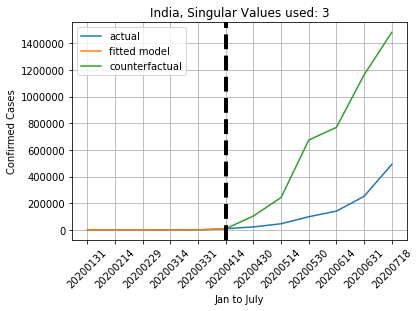

In [15]:
yearTrainEnd=20200414
fig, ax = plt.subplots(1,1)
tick_spacing = 1
# this is a bug in matplotlib
label_markings = np.insert(years[::tick_spacing], 0, 'dummy')

ax.set_xticks(np.arange(len(label_markings)))
ax.set_xticklabels(label_markings, rotation=45)
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

plt.plot(years, actual ,label='actual')
plt.xlabel('Jan to July')
plt.ylabel('Confirmed Cases')
plt.plot(trainingYears, model_fit, label='fitted model')
plt.plot(testYears, predictions, label='counterfactual')
plt.title(caStateKey+', Singular Values used: '+str(singvals))

xposition = pd.to_datetime(yearTrainEnd,  errors='coerce')
plt.axvline(x=str(yearTrainEnd), color='k', linestyle='--', linewidth=4)
plt.grid()
plt.legend()